In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

2025-11-12 08:44:17.852842: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762937058.172863      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762937058.269885      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

ModuleNotFoundError: No module named 'keras.preprocessing.text'

In [16]:
import string
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
def read_text(filename):
    with open(filename, mode='rt', encoding='utf-8') as file:
        text = file.read()
    return text

In [18]:
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [19]:
data = read_text("../input/bilingual-sentence-pairs/ara.txt")
eng_ara = np.array(to_lines(data))

In [20]:
eng_ara[:, 0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in eng_ara[:, 0]]

In [21]:
import re
def clean_arabic(text):
    # Supprimer chiffres, ponctuation et symboles non arabes
    text = re.sub(r'[A-Za-z0-9@#?!,;:()\[\]{}"\'\-=_+/\\|<>«»٪٫…]', '', text)
    # Supprimer les espaces multiples
    text = re.sub(r'\s+', ' ', text).strip()
    return text

eng_ara[:, 1] = [clean_arabic(s) for s in eng_ara[:, 1]]

In [22]:
eng_ara[:, 0] = [s.lower() for s in eng_ara[:, 0]]

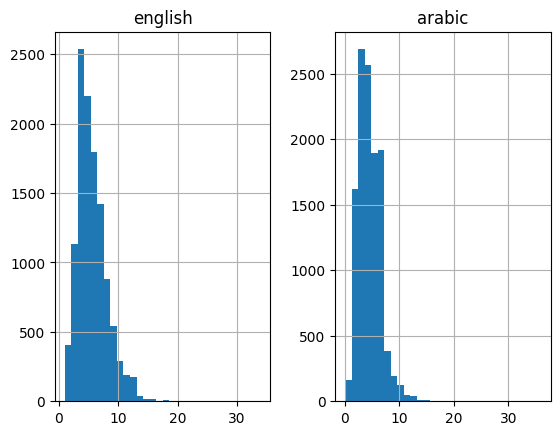

In [23]:
eng_l, ara_l = [], []

for i in eng_ara[:, 0]:
    eng_l.append(len(i.split()))

for i in eng_ara[:, 1]:
    ara_l.append(len(i.split()))

length_df = pd.DataFrame({'english': eng_l, 'arabic': ara_l})
length_df.hist(bins=30)
plt.show()

In [24]:
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# 🔠 Tokenizer anglais
eng_tokenizer = tokenization(eng_ara[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = 10
print(f'English Vocabulary Size: {eng_vocab_size}')

# 🔡 Tokenizer arabe
ara_tokenizer = tokenization(eng_ara[:, 1])
ara_vocab_size = len(ara_tokenizer.word_index) + 1
ara_length = 10
print(f'Arabic Vocabulary Size: {ara_vocab_size}')

English Vocabulary Size: 4262
Arabic Vocabulary Size: 12881


In [25]:
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

# Exemple d'encodage
X = encode_sequences(eng_tokenizer, eng_length, eng_ara[:, 0])  # anglais
y = encode_sequences(ara_tokenizer, ara_length, eng_ara[:, 1])  # arabe

print("Shape of English input:", X.shape)
print("Shape of Arabic target:", y.shape)

Shape of English input: (11668, 10)
Shape of Arabic target: (11668, 10)


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, RepeatVector, TimeDistributed, Bidirectional, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

In [27]:
train, test = train_test_split(eng_ara, test_size=0.2, random_state=12)

# Séquences encodées
trainX = encode_sequences(eng_tokenizer, eng_length, train[:, 0])  # anglais → entrée
trainY = encode_sequences(ara_tokenizer, ara_length, train[:, 1])  # arabe → sortie

testX = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_sequences(ara_tokenizer, ara_length, test[:, 1])

In [30]:
def define_bi_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    
    # Embedding (entrée anglaise)
    model.add(Embedding(input_dim=in_vocab, output_dim=units, input_length=in_timesteps, mask_zero=True))
    
    # 🔁 LSTM bidirectionnel encodeur
    model.add(Bidirectional(LSTM(units, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)))
    
    # Répétition du vecteur de contexte pour la séquence de sortie
    model.add(RepeatVector(out_timesteps))
    
    # 🔁 LSTM bidirectionnel décodeur
    model.add(Bidirectional(LSTM(units, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))
    
    # Sortie distribuée sur chaque pas de temps
    model.add(TimeDistributed(Dense(out_vocab, activation='softmax')))
    
    return model

In [31]:
model = define_bi_model(
    in_vocab=eng_vocab_size,
    out_vocab=ara_vocab_size,
    in_timesteps=eng_length,
    out_timesteps=ara_length,
    units=512
)

rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.build(input_shape=(None, eng_length))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
filename = 'eng_to_ara_bi_model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(
    trainX, 
    trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
    epochs=60,
    batch_size=256,
    validation_split=0.2,
    callbacks=[checkpoint],
    verbose=1
)

Epoch 1/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4930 - loss: 7.3423
Epoch 1: val_loss improved from inf to 3.81012, saving model to eng_to_ara_bi_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 188s 6s/step - accuracy: 0.4948 - loss: 7.2842 - val_accuracy: 0.5698 - val_loss: 3.8101
Epoch 2/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5702 - loss: 3.7567
Epoch 2: val_loss improved from 3.81012 to 3.74237, saving model to eng_to_ara_bi_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 166s 6s/step - accuracy: 0.5702 - loss: 3.7554 - val_accuracy: 0.5736 - val_loss: 3.7424
Epoch 3/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5744 - loss: 3.6188
Epoch 3: val_loss improved from 3.74237 to 3.68486, saving model to eng_to_ara_bi_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 164s 5s/step - accuracy: 0.5744 - loss: 3.6195 - val_accuracy: 0.5749 - val_loss: 3.6849
Epoch 4/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5738 - loss: 3.5859
Epoch 4: val_loss improved from 3.68486 to 3.64673, saving model to eng_to_ara_bi_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 154s 5s/step - accuracy: 0.5738 - loss: 3.5863 - val_accuracy: 0.5736 - val_loss: 3.6467
Epoch 5/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5712 - loss: 3.5905
Epoch 5: val_loss did not improve from 3.64673
30/30 ━━━━━━━━━━━━━━━━━━━━ 154s 5s/step - accuracy: 0.5713 - loss: 3.5903 - val_accuracy: 0.5746 - val_loss: 3.7300
Epoch 6/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5768 - loss: 3.5459
Epoch 6: val_loss did not improve from 3.64673
30/30 ━━━━━━━━━━━━━━━━━━━━ 163s 5s/step - accuracy: 0.5767 - loss: 3.5463 - val_accuracy: 0.5633 - val_loss: 3.8239
Epoch 7/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5704 - loss: 3.6012
Epoch 7: val_loss improved from 3.64673 to 3.61478, saving model to eng_to_ara_bi_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 156s 5s/step - accuracy: 0.5706 - loss: 3.5998 - val_accuracy: 0.5781 - val_loss: 3.6148
Epoch 8/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5766 - loss: 3.5000
Epoch 8: val_loss did not improve from 3.61478
30/30 ━━━━━━━━━━━━━━━━━━━━ 164s 5s/step - accuracy: 0.5766 - loss: 3.5000 - val_accuracy: 0.5779 - val_loss: 3.6182
Epoch 9/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5811 - loss: 3.4537
Epoch 9: val_loss improved from 3.61478 to 3.60495, saving model to eng_to_ara_bi_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 156s 5s/step - accuracy: 0.5811 - loss: 3.4542 - val_accuracy: 0.5768 - val_loss: 3.6050
Epoch 10/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5745 - loss: 3.4693
Epoch 10: val_loss did not improve from 3.60495
30/30 ━━━━━━━━━━━━━━━━━━━━ 165s 6s/step - accuracy: 0.5746 - loss: 3.4687 - val_accuracy: 0.5788 - val_loss: 3.6096
Epoch 11/60
18/30 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - accuracy: 0.5792 - loss: 3.4278 

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

In [ ]:
model = load_model('eng_to_ara_bi_model.h5')

# Prédictions
preds_probs = model.predict(testX)
preds = np.argmax(preds_probs, axis=-1)

print("✅ Predictions shape:", preds.shape)

In [ ]:
def get_word(n, tokenizer):
    """
    Retourne le mot correspondant à l'indice n dans le tokenizer.
    Si l'indice n'existe pas, retourne None.
    """
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [ ]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], ara_tokenizer)   # 🔹 utilisation du tokenizer arabe
        if j > 0:
            prev_word = get_word(i[j-1], ara_tokenizer)
            if (t == prev_word) or (t is None):
                temp.append('')
            else:
                temp.append(t)
        else:
            temp.append('' if t is None else t)
    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({
    'english_sentence': test[:, 0],   # 🔹 colonne de phrases anglaises
    'predicted_arabic': preds_text    # 🔹 traduction générée
})

In [ ]:
pred_df.head(30)